In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

In [2]:
df = pd.read_csv('labels.csv') #Read csv file.
df = df.head(1000)
df.shape

(1000, 2)

In [3]:
df['breed'].nunique()
df['filepath'] = 'train/' + df['id'] + '.jpg' #Read jpgs from folder.

In [4]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [5]:
features = df['filepath']
target = df['breed']

X_train, X_val, Y_train, Y_val= train_test_split(features, target, test_size=0.2, random_state=42) #Splitting data.

X_train.shape, X_val.shape #Shaping X.

((800,), (200,))

In [6]:
X_train_data = []
for file_path in X_train:
    img = cv2.imread(file_path)
    img = cv2.resize(img, (224, 224))  # Adjust the size based on your model requirements.
    X_train_data.append(img)

X_train = np.array(X_train_data)
Y_train = np.array(Y_train)

In [7]:
X_val_data = []
for file_path in X_val:
    img = cv2.imread(file_path)
    img = cv2.resize(img, (224, 224))  # Adjust the size based on your model requirements.
    X_val_data.append(img)

X_val = np.array(X_val_data)
Y_val = np.array(Y_val)

In [8]:
# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

In [9]:
# Define the function to create the model
def create_model(optimizer='adam', batch_size=32, epochs=10):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(Y_train)), activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
model = create_model()

# Print model summary
model.summary()

with tf.device('/device:GPU:0'):
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=25, batch_size=32) #Adjusting hyper-parameters.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

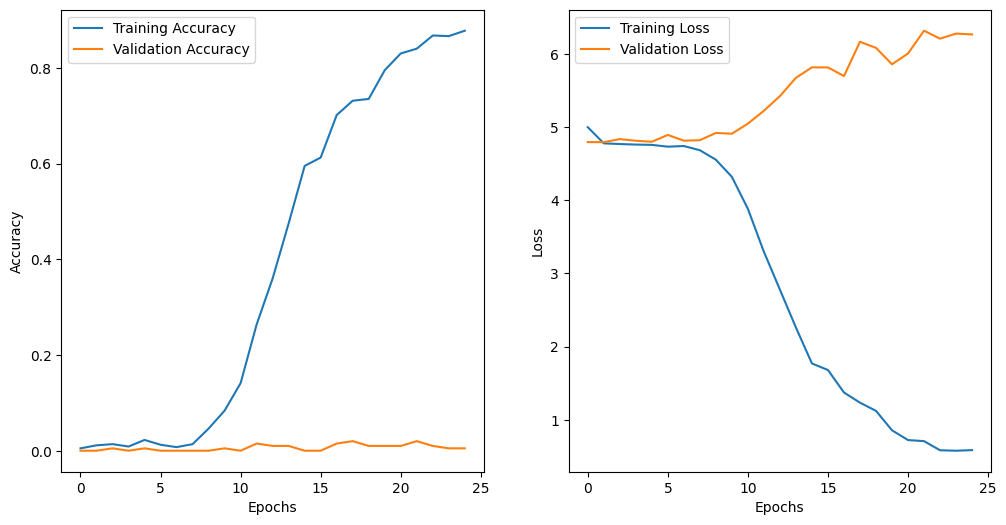

In [11]:
# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
#Printing results.
print("Training Accuracy with Optimized Parameters:", max(history.history['accuracy'] * 100))
print("Validation Accuracy with Optimized Parameters:", max(history.history['val_accuracy'] * 100))

#Note: More epochs will be better for the model.

Training Accuracy with Optimized Parameters: 0.8774999976158142
Validation Accuracy with Optimized Parameters: 0.019999999552965164
